# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print(type(states[0]))
print(type(states))
#print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        #print("\nrewards = {}\n".format(rewards))
        #print(type(rewards))
        #break
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.10000000149011612
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Multi Agent - Deep Deterministic Policy Gradient

In [6]:
import torch
from Learner import Learner
from collections import deque, namedtuple

# main training loop
def train(agent, n_episodes=10000, print_every=200):

    scores_deque = deque(maxlen=100)
    avg_scores = []
    
    # noise management
    noise_factor = 1.0
    noise_reduction = 0.9999
    t_stop_noise = 12000
    
    # index of step across episodes
    i_step = 0

    # results
    i_episode_max = 0
    max_avg_score = 0.
    
    # main loop
    for i_episode in range(1, n_episodes + 1) : 

        collected_rewards = []
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        all_states = env_info.vector_observations             # get the current state (for each agent)
        agent.reset()                                         # resets the noise
        
        # running an episode until end
        while(True) : 
            if i_step < t_stop_noise :
                all_actions = agent.act(all_states, noise_factor=noise_factor)
                noise_factor *= noise_reduction
            else :
                all_actions= agent.act(all_states, add_noise=False)
            
            env_info = env.step(all_actions)[brain_name]
            all_next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                             # get reward (for each agent)
            dones = env_info.local_done                            # see if episode finished
            
            # store experiences & learn
            states = np.array(all_states).reshape(1,-1)
            actions = np.array(all_actions).reshape(1,-1)
            next_states = np.array(all_next_states).reshape(1,-1)
            agent.step(states, actions, rewards, next_states, dones) 
            
            all_states = all_next_states
            collected_rewards.append(rewards)
            i_step += 1
            
            if np.any(dones):
                break

        rewards = np.transpose(np.array(collected_rewards)) # for 1 episode
        scores_agent = np.sum(rewards, axis = 1)
        #scores.append(np.max(scores_agent))
        scores_deque.append(np.max(scores_agent))
        avg_score = np.mean(scores_deque)
        avg_scores.append(avg_score)
        if avg_score > max_avg_score :
            torch.save(agent.actors[0].actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agent.actors[1].actor_local.state_dict(), 'checkpoint_actor_1.pth')
            max_avg_score = avg_score
            i_episode_max = i_episode
        #print('\rEpisode {} \t Average Score : {:.5f}'.format(i_episode, avg_score, end=""))
        if  i_episode % print_every == 0 :
            print('\rEpisode {} \t Average Score : {:.5f}'.format(i_episode, avg_score))

    return avg_scores, max_avg_score, i_episode_max



In [7]:
random_seed = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Hyperparams = namedtuple('Hyperparams',['batch_size', 'tau', 'lr_actor', 'lr_critic', 'update_every'])
hyperparameters = Hyperparams(32, 0.009, 5e-5, 1e-4, 2)

learner = Learner(state_size, action_size, random_seed, num_agents, device, hyperparameters)
scores, max_score, episode = train(learner, n_episodes=10000)

print("Reached a maximum average of scores (over last 100 episodes) = {:.2f} after {:d} episodes".format(max_score, episode))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Avg Score (100 last episodes)')
plt.xlabel('Episode #')
plt.savefig('scores.jpg')
plt.show()

Episode 200 	 Average Score : 0.00090
Episode 400 	 Average Score : 0.00280
Episode 600 	 Average Score : 0.00980
Episode 800 	 Average Score : 0.01280
Episode 1000 	 Average Score : 0.01570
Episode 1200 	 Average Score : 0.03870
Episode 1400 	 Average Score : 0.03180
Episode 1600 	 Average Score : 0.03380
Episode 1800 	 Average Score : 0.02820
Episode 2000 	 Average Score : 0.03670
Episode 2200 	 Average Score : 0.04520
Episode 2400 	 Average Score : 0.08570
Episode 2600 	 Average Score : 0.09280
Episode 2800 	 Average Score : 0.09160
Episode 3000 	 Average Score : 0.10640
Episode 3200 	 Average Score : 0.11330
Episode 3400 	 Average Score : 0.10470
Episode 3600 	 Average Score : 0.11640
Episode 3800 	 Average Score : 0.09780
Episode 4000 	 Average Score : 0.15590
Episode 4200 	 Average Score : 0.27480
Episode 4400 	 Average Score : 0.31620
Episode 4600 	 Average Score : 0.97320
Episode 4800 	 Average Score : 1.51600
Episode 5000 	 Average Score : 2.31770
Episode 5200 	 Average Score 

NameError: name 'plt' is not defined

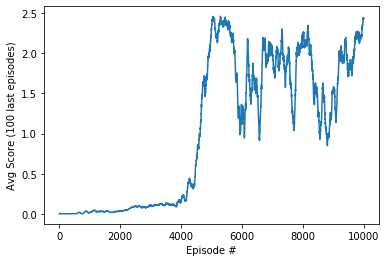

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Avg Score (100 last episodes)')
plt.xlabel('Episode #')
plt.savefig('scores.jpg')
plt.show()

### Test the agent

In [10]:
from model import ActorNetwork
actor_local_0 = ActorNetwork(state_size, action_size, random_seed)
actor_local_0.load_state_dict(torch.load('checkpoint_actor_0.pth'))
actor_local_1 = ActorNetwork(state_size, action_size, random_seed)
actor_local_1.load_state_dict(torch.load('checkpoint_actor_1.pth'))

agent  = Learner(state_size, action_size, random_seed, num_agents, device, hyperparameters)
agent.actors[0].actor_local = actor_local_0
agent.actors[1].actor_local = actor_local_1

for i in range(1, 10):                                     # play game for 10 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states, add_noise=False)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.600000038743019
Score (max over agents) from episode 2: 2.7000000402331352
Score (max over agents) from episode 3: 2.7000000402331352
Score (max over agents) from episode 4: 2.600000038743019
Score (max over agents) from episode 5: 2.7000000402331352
Score (max over agents) from episode 6: 2.7000000402331352
Score (max over agents) from episode 7: 2.600000038743019
Score (max over agents) from episode 8: 2.7000000402331352
Score (max over agents) from episode 9: 2.7000000402331352
